In [1]:
import ptyrodactyl.photons as ptp
import jax 
import jax.numpy as jnp
from jaxtyping import Array, Float, Shaped, Int, Complex
import matplotlib.pyplot as plt
from beartype.typing import Tuple

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pixel_spacing_real = 200/(10**9)
collimated_beam_waist = 10/(10**3)
image_fov_x = 450/(10**6)
image_fov_y = 450/(10**6)
wavelength = 633/(10**9)

In [4]:
num_pixels = image_fov_y/pixel_spacing_real
num_pixels

2250.0

In [5]:
xo = jnp.arange(start=-num_pixels/2, stop=num_pixels/2, step=1)
Xo, Yo = jnp.meshgrid(xo, xo)
Ro = ((Xo**2) + (Yo**2))**0.5

In [6]:
def generate_spiral_image(shape: Tuple[int, int]):
    H, W = shape
    
    # Create coordinate grids
    y, x = jnp.mgrid[0:H, 0:W]
    
    # Center the coordinates
    center_y, center_x = H // 2, W // 2
    y = y - center_y
    x = x - center_x
    
    # Convert to polar coordinates
    r = jnp.sqrt(x**2 + y**2)
    theta = jnp.arctan2(y, x)
    
    # Adjust theta to be in [0, 2π]
    theta = jnp.where(theta < 0, theta + 2 * jnp.pi, theta)
    
    # Golden ratio
    phi = (1 + jnp.sqrt(5)) / 2
    
    # Calculate the Fibonacci spiral
    # The Fibonacci spiral follows r = a * phi^(2*θ/π)
    # We'll normalize based on the image dimensions
    max_dim = max(H, W)
    a = max_dim / (4 * phi**(4))  # Scaling factor
    
    # Calculate the ideal radius at each point
    ideal_r = a * phi**(2 * theta / jnp.pi)
    
    # Create the spiral by measuring how close each point is to the ideal spiral
    # We'll use a smooth transition function for the spiral
    width = max_dim / 30  # Width of the spiral line
    spiral = jnp.exp(-((r - ideal_r) ** 2) / (2 * width ** 2))
    
    # Normalize to [0, 1]
    spiral = spiral / jnp.max(spiral)
    
    return spiral

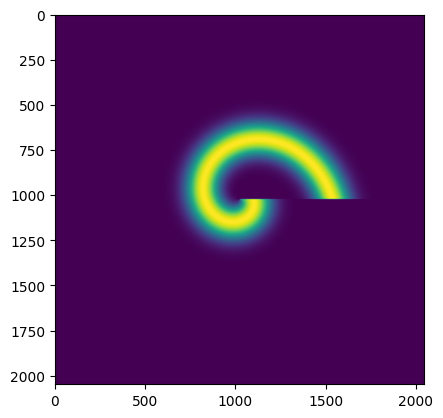

In [7]:
#starting_object = jnp.ones(shape=(2048, 2048), dtype=jnp.complex128)
starting_object = (generate_spiral_image(shape=(2048, 2048))).astype(jnp.complex128)
plt.imshow(jnp.abs(starting_object))

In [8]:
object_dx = 3.45/(10**6)
z0 = 0.0
starting_wave = ptp.OpticalWavefront(starting_object, wavelength, object_dx, z0)

In [9]:
after_aperture = ptp.circular_aperture(starting_wave, 1000/(10**6))

In [10]:
after_aperture

OpticalWavefront(field=Array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],      dtype=complex128), wavelength=6.33e-07, dx=3.45e-06, z_position=0.0)

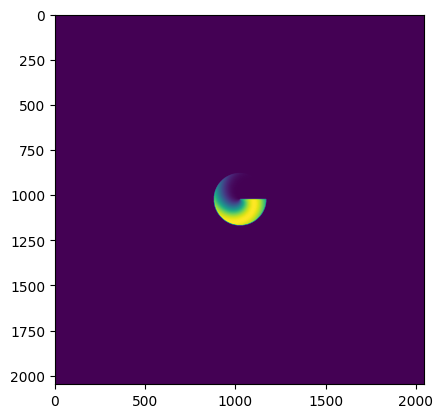

In [11]:
plt.imshow(jnp.abs(after_aperture.field))

In [12]:
distance = 110/1000
prop_to_detector_fraun = ptp.fraunhofer_prop(after_aperture, distance)
prop_to_detector_fresn = ptp.fresnel_prop(after_aperture, distance)
prop_to_detector_aspec = ptp.angular_spectrum_prop(after_aperture, distance)

detector_image_fraun = jnp.abs(prop_to_detector_fraun.field)**2
detector_image_fresn = jnp.abs(prop_to_detector_fresn.field)**2
detector_image_aspec = jnp.abs(prop_to_detector_aspec.field)**2

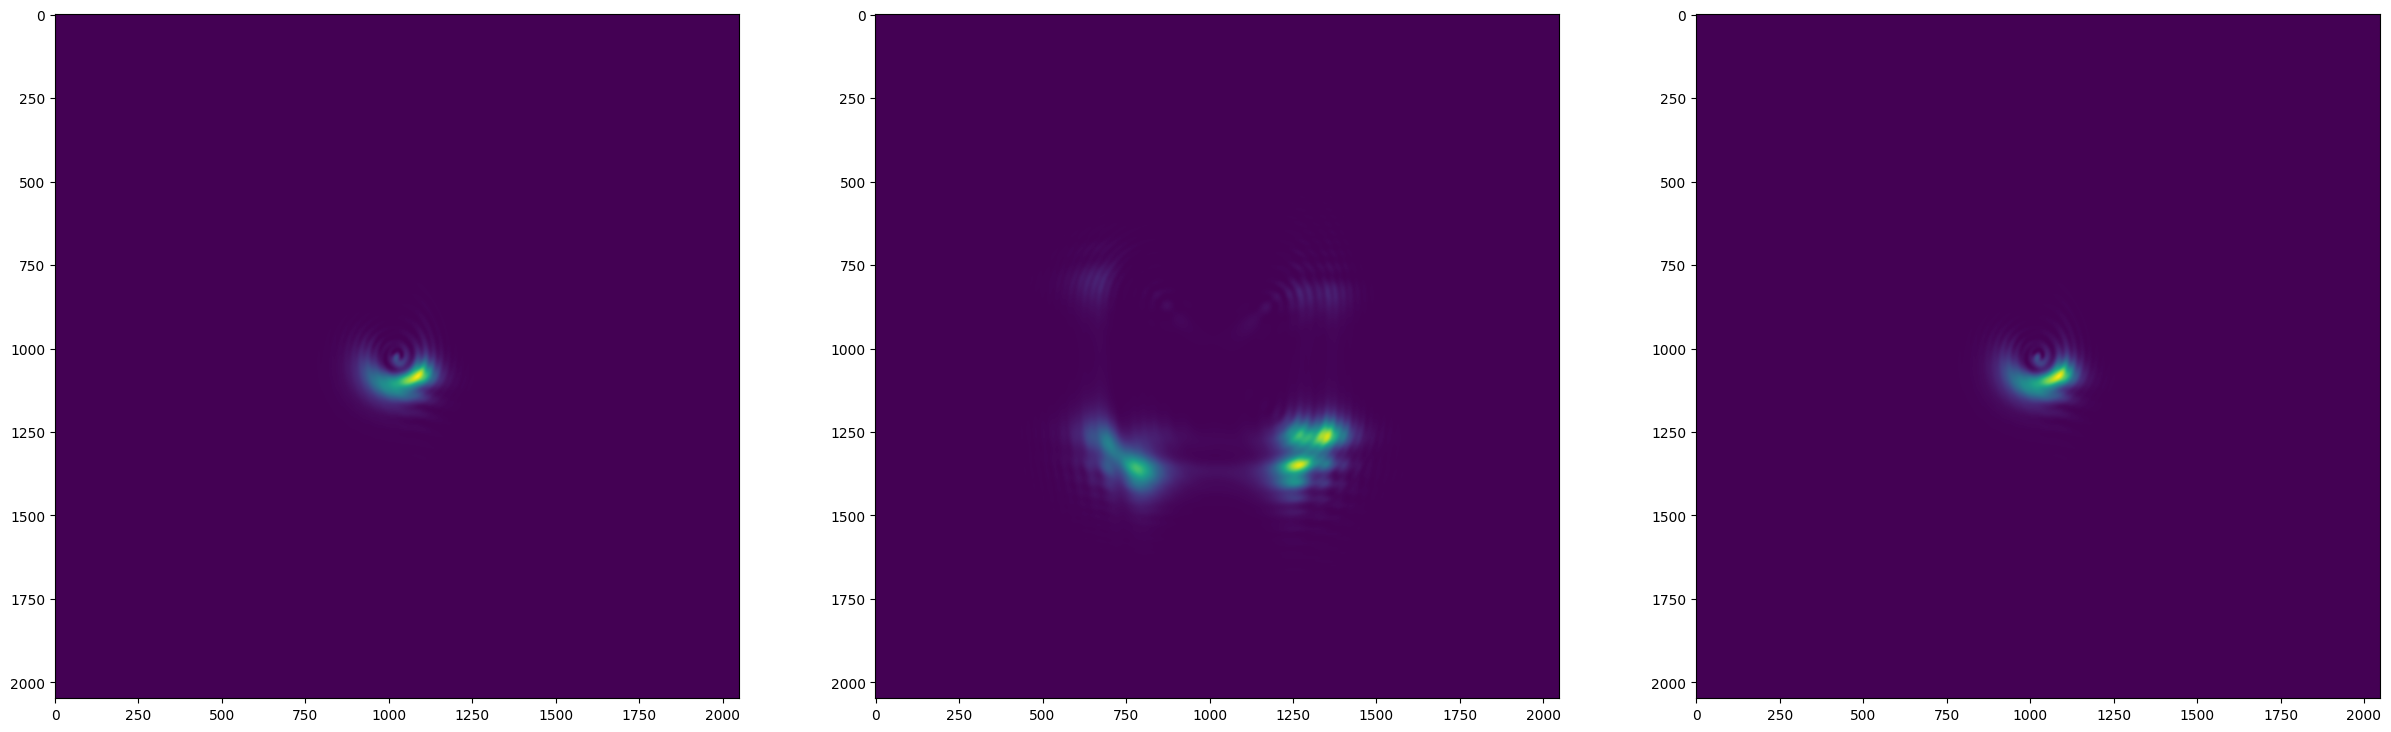

In [13]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(detector_image_fraun)
plt.subplot(1, 3, 2)
plt.imshow(detector_image_fresn)
plt.subplot(1, 3, 3)
plt.imshow(detector_image_aspec)

In [14]:
def diffractogram(initial_sample, zoom_factor, aperture_size, distance):
    zoomed_wave = ptp.zoom_wavefront(initial_sample, zoom_factor)
    aperture_wavefront = ptp.circular_aperture(zoomed_wave, aperture_size)
    at_detector = ptp.fraunhofer_prop(aperture_wavefront, distance)
    detector_image = jnp.square(jnp.abs(at_detector.field))
    return detector_image

In [16]:
%timeit diffractogram(starting_wave, 10.0, 1/1000, 110/1000)

40.9 ms ± 78.2 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


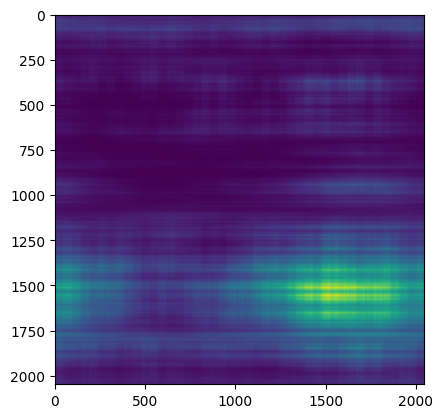

In [25]:
plt.imshow(diffractogram(starting_wave, 10.0, 1/1000, 110/1000))

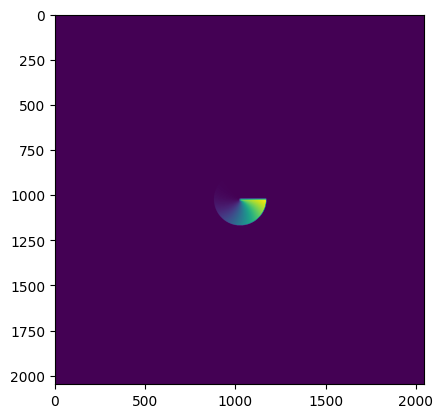

In [23]:
plt.imshow(jnp.abs(ptp.circular_aperture(ptp.zoom_wavefront(starting_wave, 10), 1/10000).field))